# Intoduction
The main goal of this work is to develop a CNN capable of solving the Dogs vs Cats classification task. <br> I am not taking this work too serious, I consider it to be a decent practice, so, here it is a hand-made meme:


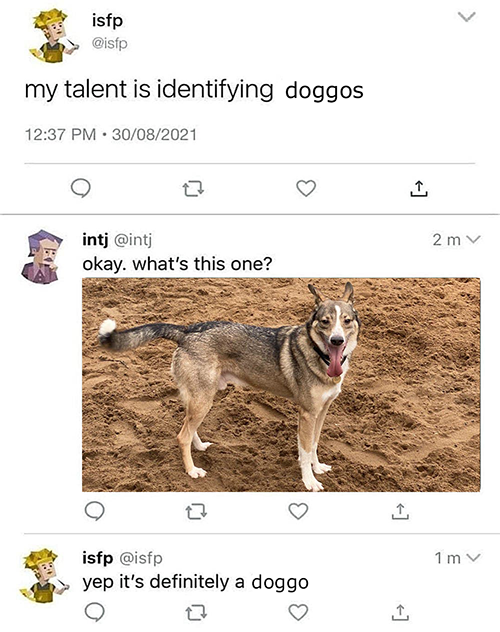


In [ ]:
# Importing packages

import pandas as pd
import numpy as np
import os
from zipfile import ZipFile as zipper
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Create a dataset
First of all we should deal with the .zip files and extract its content into two different folders: train and test.


In [ ]:
os.listdir('../input/dogs-vs-cats')

In [ ]:
train_path = '../input/dogs-vs-cats/train.zip'
test_path = '../input/dogs-vs-cats/test1.zip'

destination = '/kaggle/files/images'

with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)

Now we define a pandas dataframe adding a binary and a categorical label for each image.


In [ ]:
train = pd.DataFrame({'file': os.listdir('/kaggle/files/images/train')})
labels = []
binary_labels = []
for i in os.listdir('/kaggle/files/images/train'):
    if 'dog' in i:
        labels.append('dog')
        binary_labels.append(1)
    else:
        labels.append('cat')
        binary_labels.append(0)

train['labels'] = labels
train['binary_labels'] = binary_labels
test = pd.DataFrame({'file': os.listdir('/kaggle/files/images/test1')})

Train dataframe includes each photo filename, category and binary labels, and it´s the data we are goind to use for training our CNN, while test dataframe doesn´t have any labels and could be used only to submit our predictions to the competition. In further cells we will split our labeled data into train set and a validation one to properly measure our model performance.

In [ ]:
train.head()


In [ ]:
test.head()

# Visualize the data

We will only plot some sample images from train data to not to enlarge the notebook with useless plots.


In [ ]:
filepath = '/kaggle/files/images/train/'
fig = plt.figure(1, figsize = (20, 20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    pic = PIL.Image.open(filepath + os.listdir(filepath)[i])
    plt.imshow(pic)
    plt.axis('off')

plt.show()

# Data Preparation

As usual, train_test_split() method is used to split the trainig and test data sets by 90% and 10% respectivelly.



In [ ]:
train_set, val_set = train_test_split(train,
                                     test_size=0.1)
print(len(train_set), len(val_set))

## Making sharper edges

Recently I came up with adding another step to our image pre-processing which, in theory, could make the job easier for the model to distinguish a dog from the cat. In the cell below, you can see some easy code lines to make the image a little bit sharper. We will see if this helps our model later on.

In [ ]:
img = PIL.Image.open(filepath + os.listdir(filepath)[1])
img_new = img.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=150))
fig = plt.figure(1, figsize = (20, 20))
plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img_new)
plt.axis('off')

As you can see the transofmation mentioned above results to make too much useless noise on the image, so we set the *percent* value to 100 instead of 150.

In [ ]:
img = PIL.Image.open(filepath + os.listdir(filepath)[1])
img_new = img.filter(PIL.ImageFilter.UnsharpMask(radius=1, percent=100))
fig = plt.figure(1, figsize = (20, 20))
plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img_new)
plt.axis('off')

Now we apply our pre-processing to each image in train folder and rewrite them using the code below:

In [ ]:
for i in tqdm(range(len(os.listdir(filepath)))):
        pic_path = filepath + os.listdir(filepath)[i]
        pic = PIL.Image.open(pic_path)
        pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100))
        pic_sharp.save(pic_path)

## Generate training - validation sets
In the cell below, I define the generators for both train and validation sets. Note that the normalization of input values (1./255 rescaling) is used in both cases. Also, I set the batchsize value to 128. The reason for it is the model I use is similar to VGG16 which uses 128 batchsize for training, but we'll cover this later on.


In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
batch_size = 128


train_generator = train_gen.flow_from_dataframe(
    dataframe = train_set,
    directory = destination + '/train/',
    x_col = 'file',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)


validation_generator = val_gen.flow_from_dataframe(
    dataframe = val_set,
    directory = destination + '/train/',
    x_col = 'file',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size,
    shuffle = False
)

## Data augmentation
In this section we will define some light data augmentation to avoid the possible overfitting of the model and in further cells, when building it, data_augmentation will be its first step

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Model

## VGG16 overall & architecture

The model I build in the following section is inspired by the VGG16 architecture. Long story short, after AlexNet publication (the first CNN in using more than one consecutive convolutional layers)the VGG16 by K. Simonyan and A. Zisserman proposed similar idea of stacking convolutional layers without pooling in between, in order to improve the feature caption and overall model performance. My model is very similar to one of the VGG16 model configurations, yet sifnificantly more simple and doesn't require as much computational power as does his VGG16 analogue. You can find the standart VGG16 Architecture in the image down below:
![StandartVGG16Architecture](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

## Build the model

In [ ]:
input_shape = (224, 224, 3)
n_class = 2
korobka = Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'softmax')
])

In [ ]:
korobka.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

## Model summary

In [ ]:
korobka.summary()

## Callbacks

Early stopping callback is used to avoid overfitting during the training process of many neural networks, not only the CNN. It basically stops the model if an indicator (we can shoose one we want to monitor) doesn´t improve within the specified epochs of patience (3 in my case). Note that when setting the early stopping callback, we would rather monitor the validation set loss, than its accuracy score. In case we still want to monitor the accuracy instead of the loss (this may vary depending on the task) the *mode* argument needs to be set to *max*, because we want the maximum accuracy, but the minimum loss.

In [ ]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    verbose = 1,
    mode = "min")

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

## Train the model

In [ ]:
with tf.device('/device:GPU:0'):
    epochs=40
    history = korobka.fit_generator(train_generator, 
                            validation_data=validation_generator, 
                            epochs=epochs,
                            validation_steps = val_set.shape[0] // batch_size,
                            steps_per_epoch = train_set.shape[0] // batch_size, callbacks = [early_stopping])

# Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(28)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on validation set

In [ ]:
with tf.device('/device:GPU:0'):
    val_pred = korobka.predict(validation_generator, steps = np.ceil(val_set.shape[0] / batch_size))

In [ ]:
val_set['normalpreds'] = np.argmax(val_pred, axis = -1)
labels = dict((v,k) for k,v in train_generator.class_indices.items())

val_set['normalpreds'] = val_set['normalpreds'].map(labels)

In [ ]:
val_set.head(20)

# Interpret the results

## Confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_set["labels"], val_set["normalpreds"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cat", "dog"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()

## Classification report

In [ ]:
print(classification_report(val_set["labels"], val_set["normalpreds"]))

# Conclusions
This section is dedicated to show all the versions of the model and the corresponding classification reports. It's easy to follow step by step either how I managed to improve the initial model or the changes and decisions made to do so.

## KOROBKA using data augmentation 

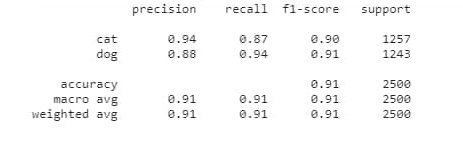

## KOROBKA using pre-processing and data augmentation

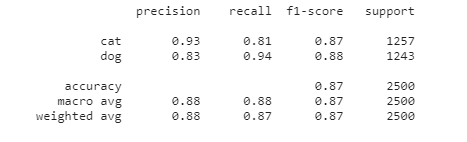

## KOROBKA using pre-processing, data augmentation and dropout

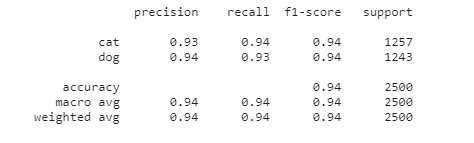

# Save the model

In [ ]:
!mkdir -p saved_models
korobka.save('saved_models/korobka_v3')
os.listdir('saved_models/korobka_v3')

# Afterword
This is the last section of this notebook, and frankly, I am pretty satisfied with the work done so far. The final model shows 94% accuracy without trasfer learning neither complex structure or pre-processing, which is basically an outstanding result. Glad to claim this notebook has achieved all its prior goals.
Thank you very much for you attention, all the comments and suggestions are welcome.